In [1]:
import pandas as pd
from pandas import Series, DataFrame
import codecs

In [2]:
#Video_idの被りを省く
with codecs.open("JPvideos.csv", "r", "UTF-8", "ignore") as file:
    df =  pd.read_csv(file)
    df.drop_duplicates(subset='video_id', keep='last', inplace=True)

In [3]:
#必要のないと思われるCategoryID
remove_CategoryID = [3,4,5,6,7,8,9,11,12,13,14,16,28]
for n in remove_CategoryID:
    df = df[df["category_id"]!=n]

In [4]:
#再生数が50万を超えている動画のみ
df = df[df["views"]>500000]

In [5]:
#[]が含まれるなら1,含まれないなら0

buzz_word_Braces = ["【","】"]
for i in buzz_word_Braces:
    df.loc[df['title'].str.contains(i),"title_encode_Braces"] = 1
df.loc[df['title_encode_Braces'].isnull(),"title_encode_Braces"] = 0

In [6]:
#バズりやすい言葉があれば1,それ以外を0

buzz_word = ["神回","悲報","www","衝撃","危険","危機"]
for n in buzz_word:
    df.loc[df['title'].str.contains(n),"title_encode_word"] = 1
df.loc[df['title_encode_word'].isnull(),"title_encode_word"] = 0

In [7]:
#メッセージの長さ
df['len_title'] = df['title'].apply(lambda x: len(str(x).replace(' ', '')))
df["len_title"].describe()

count    1083.000000
mean       41.727608
std        19.195382
min         3.000000
25%        27.000000
50%        38.000000
75%        55.000000
max        97.000000
Name: len_title, dtype: float64

In [8]:
df.loc[df['len_title'] > 45,"title_encode_len"] = 2
df.loc[df['len_title'] < 45 ,"title_encode_len"] = 1
df.loc[df['len_title'] < 24,"title_encode_len"] = 0

In [9]:
#100万再生なら1,違うなら0とする
df.loc[df['views'] > 1000000,"view_encode"] = 1
df.loc[df['view_encode'].isnull(),"view_encode"] = 0

In [10]:
#データフレームを整える
df2 = df[['title_encode_Braces','title_encode_word','title_encode_len']]
df2 = df2.fillna(0)

In [11]:
#データの可視化
df_ex = df[['title_encode_Braces','title_encode_word','title_encode_len','view_encode']]
df_ex = df_ex.fillna(0)
df_ex.describe()

,title_encode_Braces,title_encode_word,title_encode_len,view_encode
count,1083.000000,1083.000000,1083.000000,1083.000000
mean,0.192059,0.019391,1.204986,0.496768
std,0.394101,0.137957,0.708082,0.500221
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,2.000000,1.000000
max,1.000000,1.000000,2.000000,1.000000


In [12]:
#モデルの構築
import numpy as np
import numpy.random as random
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = df2
Y = df['view_encode']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
y_train.head()

3392     0.0
16303    1.0
15306    1.0
5597     1.0
14476    1.0
Name: view_encode, dtype: float64

In [13]:
#決定木

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# 決定木インスタンス(木の深さ3)
model = DecisionTreeClassifier(max_depth=5)
#学習モデル構築。引数に訓練データの特徴量と、それに対応したラベル
model.fit(X_train, y_train)
predicted = model.predict(X_test)

# .scoreで正解率を算出。
print("train score:",model.score(X_train,y_train))
print("test score:",model.score(X_test,y_test))

train score: 0.5689655172413793
test score: 0.5166051660516605


In [14]:
#混同行列の作成
plot_cm = confusion_matrix(predicted,y_test)
plot_cm

array([[46, 42],
       [89, 94]])

In [15]:
#グラフ表示に必要なモジュールのインストール
!pip install graphviz
!pip install seaborn

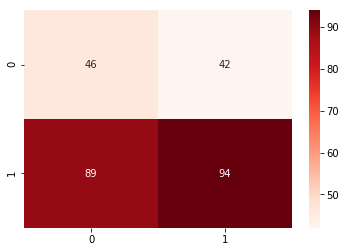

In [17]:
#混同行列の可視化
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(plot_cm, annot=True, cmap='Reds')

In [27]:
#決定木の出力
with open('YouTube-dtree.dot', mode='w') as f:
    tree.export_graphviz(model, out_file=f)

In [30]:
!dot -T png YouTube-dtree.dot -o YouTube-dtree.png
!open YouTube-dtree.png

In [25]:
# サポートベクターマシン（SVM）
from sklearn.svm import LinearSVC

# SVMインスタンス
model = LinearSVC()
#学習モデル構築。引数に訓練データの特徴量と、それに対応したラベル
model.fit(X_train, y_train)

# .scoreで正解率を算出。
print("train score:",model.score(X_train,y_train))
print("test score:",model.score(X_test,y_test))

train score: 0.5603448275862069
test score: 0.5350553505535055
